# Prueba 12: Algoritmo definitivo

Probamos el algoritmo definitivo (según Pere)

Usamos x = c ln (lambda)



In [1]:
from PyAstronomy import pyasl
from astropy.io import fits
from astropy.wcs import WCS
from scipy.constants import c
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
%matplotlib inline


Primero definimos el módulo de lectura del espectro. Sin cambios respecto otras versiones.

In [2]:
def readSpec(filename, path):
    
    sp = fits.open(path + filename)
    header = sp[0].header
      
    tf = sp[0].data
    tf = tf.flatten()
 
    wvl, flx = pyasl.read1dFitsSpec(path + filename)
 
    sp.close()

    date_obs = header['DATE']

    return header, wvl, flx, date_obs, tf
    
    '''
    sp = fits.open(path + filename)
    header = sp[0].header
    
    tf = sp[0].data
    tf = tf.flatten()    
    
    wcs = WCS(header)
    index = np.arange(header['NAXIS1'])

    wavelength = wcs.wcs_pix2world(index[:,np.newaxis], 0)
    wavelength = wavelength.flatten()  
    
    flux = sp[0].data
    sp.close()

    date_obs = header['DATE']

    return header, wavelength, flux, date_obs, tf
    '''

Módulo que salva el espectro obtenido.

In [3]:
def saveSpectrum(filename, header, wavelength, flux, date_obs):
    
    answer = input("Save spectra " + filename + "(y/N)?")
    if answer == "y" or answer == "Y":
    
        header['CRVAL1'] = wavelength[0]
        header['DATE'] = date_obs
        hdu = fits.PrimaryHDU(flux, header)
        hdu.writeto(filename, overwrite=True)  
   

Función que dibuja el espectro.

In [4]:
def plotSpectrum(wavelength, flux, legend):

    fig= plt.figure(figsize=(15,5))  #el mejor: 15,5 pero 6,4 puede usarse para tamaño pequeño
    axes= fig.add_axes([0.1,0.1,0.8,0.8])
    axes.plot(wavelength, flux)
    plt.xlabel(legend)
    plt.ylabel('flux')
    plt.show()

Módulo para salvar espectros

In [5]:
def save_spec(filename, header, wave, flux, date_obs):
    print("Fecha obs:")
    print(date_obs)
     
    header['CRVAL1'] = wave[0]
    header['DATE'] = date_obs
    hdu = fits.PrimaryHDU(flux, header)
    hdu.writeto(filename, overwrite=True)   

Entrada de datos de cada espectro observacional. Los datos se pueden introducir manualmente o modificando las listas existentes. Se introduce, además, la contribución del espectro B.

In [6]:
def peaks(star, spectra, enter_data):
    
    values = []
    reference_line = float(input("Enter reference line (in A) for spectrum " + star + " and RV=0: "))
    print("-------------")
    if enter_data == "manual":
        print("Enter reference lines for spectrum " + star)
        print("REMEMBER: if unclear or blended, please enter '0'")
        for i in spectra:
            value = float(input("Enter reference line (in A) for spectrum " + i + " :"))
            if value != 0:
                values.append(value)
            else:
                values.append(10000000000) 
        print(values)
                
    elif enter_data == "list":           
        if star == "A":
            #values=[4465.54, 4468.53, 4470.01, 4466.3, 4467.77, 4469.27, 4467.05, 10000000000, 4471.51, 4464.78]
            values = [4339.8, 4339.83, 4340.21]
        elif star == "B":
            #values=[4535.49, 4532.36, 10000000000, 4534.79, 4533.23, 4531.76, 4534.01, 10000000000, 4529.55, 4536.20]
            values = [4470.17, 4470.38, 4470.19]
    if star == "B":
        weight_sp = float(input("Contribution of spectrum B to the entangled spectra (0.0-1.0): "))
    else:
        weight_sp = 0    

    return reference_line, np.asarray(values), weight_sp


Conversión a x = c ln (lambda) y cálculo de los desplazamientos Doppler

In [7]:
def dopplerShift(reference_band, peaks):
    
    doppler_shift = []
    l_peaks = log_wave(peaks)
    l_reference_band = log_wave(reference_band)
    for i in range(len(l_peaks)):
        if l_peaks[i] != 0:
            doppler_shift.append(l_peaks[i] - l_reference_band)
        else:
            doppler_shift.append(None)
    
    return doppler_shift    
    

#### Pasos 1, 2, 4, 5 del algoritmo
Esta rutina desplaza Aj o Bj hasta coincidir con las bandas de la componente A o B del espectro observacional Si. Entonces calcula Bji+1 = Si-Aj o Aji+1 = Si-Bj para todos los espectros Si, obteniendo todos los Bji+1 o Aji+1 cuyas bandas han podido identificarse con claridad.

In [8]:
def calcSi_Xj(Si_flux, doppler_shift, l_wavelength, flux, weight_sp):
    
    Si_Xj = []
    for i in range(len(Si_flux)):
        if doppler_shift[i] != None:
            dl_wavelength = l_wavelength - doppler_shift[i]
            d_flux = np.interp(dl_wavelength, l_wavelength, flux) * weight_sp
            Si_Xj.append(Si_flux[i] - d_flux)        
        else:
            Si_Xj.append(None)
    
    return Si_Xj

#### Pasos 3 y 6 del algoritmo
Esta rutina desplaza todos los espectros Aji+1 o Bji+1 hasta que coincidan sus bandas, y las promedia para obtener Aj+1 o Bj+1.

In [9]:
def calcYj(Si_Xj, doppler_shift, Si_l_wavelength, weight_sp, iterator):
    
    d_Si_Xj = []
    for i in range(len(Si_Xj)):
        if doppler_shift[i] != None:
            dl_wavelength_Si_Xj = Si_l_wavelength[i] - doppler_shift[i]
            d_flux_Si_Xj = np.interp(dl_wavelength_Si_Xj, Si_l_wavelength[i], Si_Xj[i])
            d_Si_Xj.append(d_flux_Si_Xj) 

    print("*** Calculated " + iterator + " ***")
    flux_Yj = np.mean(d_Si_Xj, axis = 0) / weight_sp
    plotSpectrum(Si_l_wavelength[0], flux_Yj, 'log (wavelength(A))')
    
    return flux_Yj

### Núcleo del programa.
Definición de variables.
Lectura de espectros observacionales.
Introducción de las bandas de referencia de cada espectro.
Proceso iterativo de disentangling y presentación de resultados.

Introduce data manual or through a list (m/L)?
Enter reference line (in A) for spectrum A and RV=0: 4340.43
-------------
Enter reference line (in A) for spectrum B and RV=0: 4471.44
-------------
Contribution of spectrum B to the entangled spectra (0.0-1.0): 0.45
Enter B0 spectrum: ref20000rw_400dnoise

Initial mixed spectrum 2MASS_ALFOSCGR18_20160525rn_r.fits


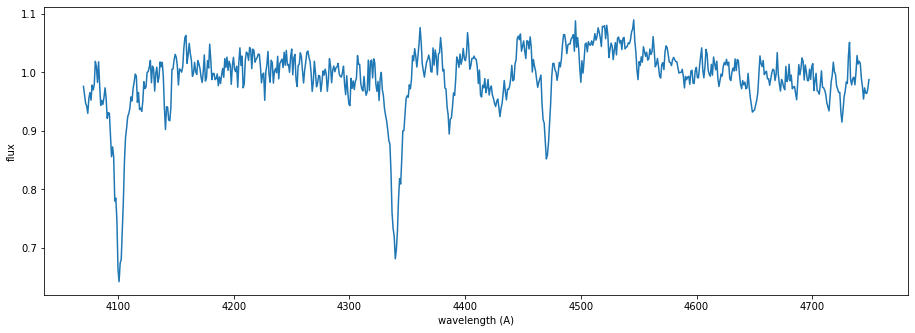

B0 spectrum:


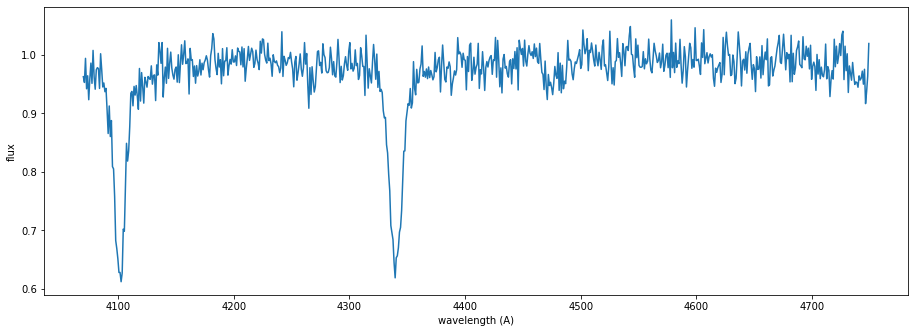

++++++++ Iteration 1 ++++++++
*** Calculated A1 ***


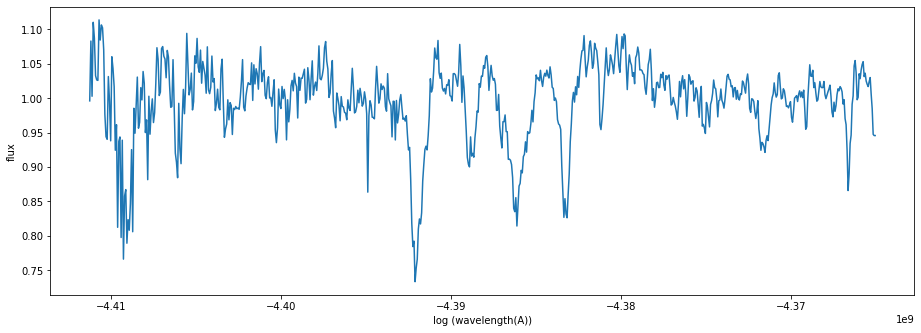

*** Calculated B1 ***


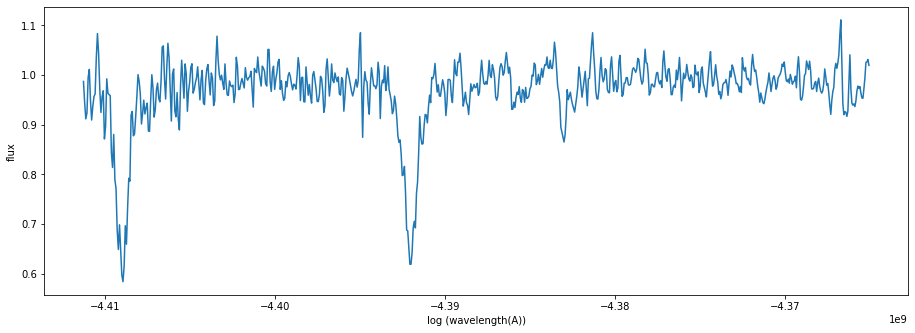

Another iteration (Y/n)?
++++++++ Iteration 2 ++++++++
*** Calculated A2 ***


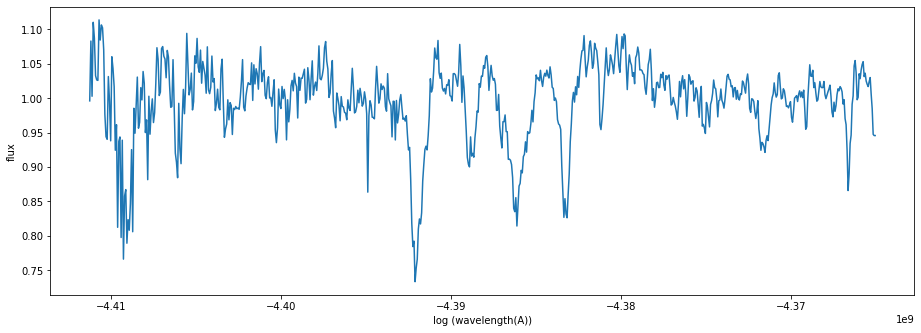

*** Calculated B2 ***


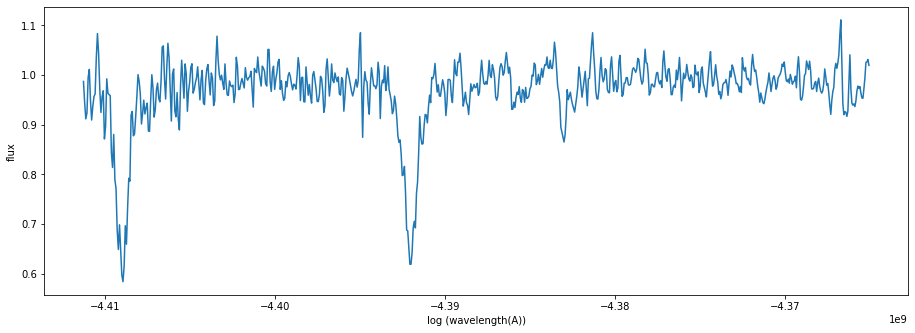

Another iteration (Y/n)?n
You did 2 iterations.
***** Disentangled Spectrum A *****


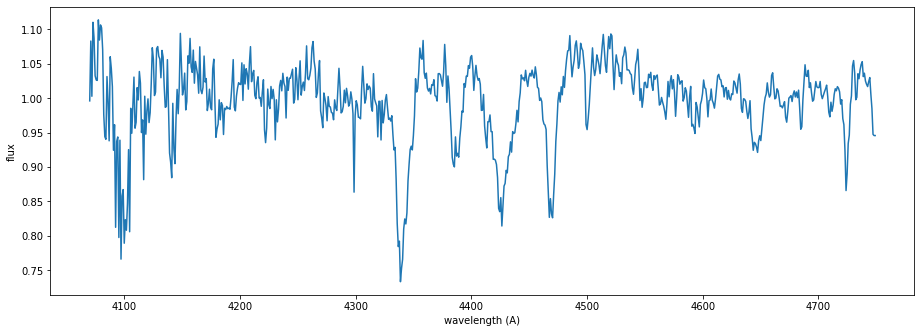

***** Disentangled Spectrum B *****


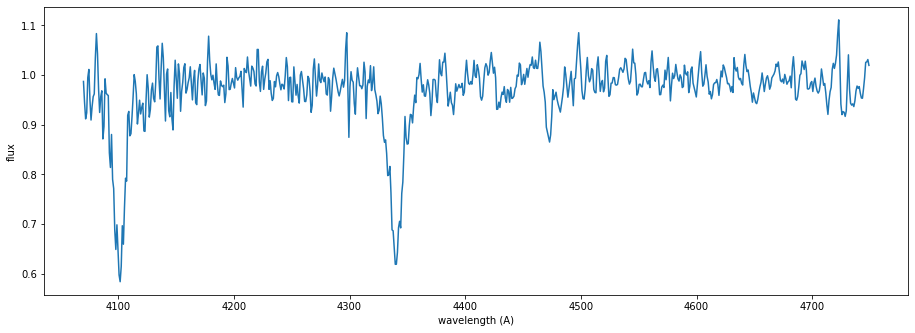

********************
Save disentangled spectra (y/N)?y
Enter spectrum A name:Rotadora_rapida_componente_A
Fecha obs:
2015-07-12
Enter spectrum B name:Rotadora_rapida_componente_B
Fecha obs:
2015-07-12
End


In [10]:
path = "/home/fran/PythonProjects/TFM/Rotadora rapida/"
path_B0 = "/home/fran/PythonProjects/TFM/Rotadora rapida/B0/" 
spectra = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]

#Define lists, variables amb lambda functions
Si_flux = []
Si_l_wavelength = []
peaks_A = []
peaks_B = []
cont = ""
iterator = 0
log_wave = lambda l: c*np.log(l*float(pow(10, -10)))
inv_log_wave = lambda x: (np.exp(x/c))/float(pow(10, -10))

#Read spectra and convert into logarithmic scale
for i in spectra:
    header, wavelength, flux, date_obs, tf = readSpec(i, path)
    wavelength = np.asarray(wavelength)
    flux = np.asarray(flux)
    l_wavelength = log_wave(wavelength)
    
    Si_l_wavelength.append(l_wavelength)
    Si_flux.append(flux)    
    
#Define reference bands and reference as ln (lambda)
enter_data = input("Introduce data manual or through a list (m/L)?")
if enter_data == "m" or enter_data == "M":
    reference_band_A, peaks_A, weight_sp_A = peaks("A", spectra, "manual")
    reference_band_B, peaks_B, weight_sp_B = peaks("B", spectra, "manual")
else:
    reference_band_A, peaks_A, weight_sp_A = peaks("A", spectra, "list")
    reference_band_B, peaks_B, weight_sp_B = peaks("B", spectra, "list")
    
# Convert reference lines into logarithmic scale and calculate Doppler shifts
doppler_shift_A = dopplerShift(reference_band_A, peaks_A)
doppler_shift_B = dopplerShift(reference_band_B, peaks_B)

#Load B0 spectrum
#flux_B0 = []
B0 = input("Enter B0 spectrum: ")
nheader_B0, wavelength_B0, flux_B0, date_obs_B0, tf_B0 = readSpec(B0+".fits", path_B0)
#for i in range(len(flux)):
#    flux_B0.append(1.0)
l_wavelength_B0 = log_wave(wavelength_B0)

print("")
print("Initial mixed spectrum " + spectra[0])
plotSpectrum(wavelength, Si_flux[0], 'wavelength (A)')
#plotSpectrum(Si_l_wavelength[0], Si_flux[0], 'ln (wavelength (A))')

print("B0 spectrum:")
plotSpectrum(wavelength_B0, flux_B0, 'wavelength (A)')   

#Iterative disentangling process
flux_Bj_1 = flux_B0
while cont != "N" and cont != "n":
    iterator += 1
    print("++++++++ Iteration " + str(iterator) + " ++++++++")
    
    #Step 1 and 2: Displace B0 and calculate Si-B0
    Si_Bj = calcSi_Xj(Si_flux, doppler_shift_B, l_wavelength_B0, flux_Bj_1, weight_sp_B)

    #Step 3: Displace Si-B0 and calculate A1
    Aj = calcYj(Si_Bj, doppler_shift_B, Si_l_wavelength, 1 - weight_sp_B, "A" + str(iterator))  
        
    #Step 4 and 5: Displace A1 and calculate Si-A1
    Si_Aj = calcSi_Xj(Si_flux, doppler_shift_A, l_wavelength_B0, Aj, 1 - weight_sp_B)
    
    #Step 6: Displace Si-A1 and calculate B1
    Bj = calcYj(Si_Aj, doppler_shift_A, Si_l_wavelength, weight_sp_B, "B" + str(iterator))

    #Step 7: Return to Step 1 and repeat with B1
    Bj_1 = Bj
    cont = input("Another iteration (Y/n)?")

#Final results and recalibration in lambda   
print("You did " + str(iterator) + " iterations.")
wavelength = inv_log_wave(l_wavelength_B0)
print("***** Disentangled Spectrum A *****")
plotSpectrum(wavelength, Aj, 'wavelength (A)')
print("***** Disentangled Spectrum B *****")
plotSpectrum(wavelength, Bj, 'wavelength (A)')

#Saving spectra
print("********************")
saveData = input("Save disentangled spectra (y/N)?")
if saveData =="y":    
    fileSpectrum = input("Enter spectrum A name:")
    fileSpectrum +=".fits"
    save_spec(fileSpectrum, header, wavelength, Aj, date_obs)
    fileSpectrum = input("Enter spectrum B name:")
    fileSpectrum +=".fits"
    save_spec(fileSpectrum, header, wavelength, Bj, date_obs)

print("End")
